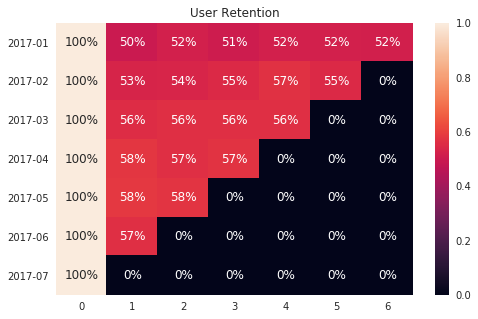

In [7]:
from elasticsearch import Elasticsearch
import json
import re
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
import math

es = Elasticsearch("http://192.168.1.35:9200")
result = es.search(
    index="child",
    body={
        "size": 0,
        "aggs": {
            "Group by register date": {
                "date_histogram": {
                    "field": "register_Date",
                    "interval": "month"
                },
                "aggs": {
                    "Group by access date": {
                        "date_histogram": {
                            "field": "access_Date",
                            "interval": "month"
                        },
                        "aggs": {
                            "uniqe by ID": {
                                "cardinality": {
                                    "field": "user_ID"
                                }
                            }
                        }
                    }
                }
            }
        }
    }
) #get data from elasticsearch database


# #python dictionary
result_dict = json.loads(json.dumps(result)) #convert data to python dictionary

D1array = result_dict['aggregations']['Group by register date']['buckets']

graphIndex = []
yearDist = re.compile("(\d*-\d*)-\d*T00:00:00.000Z")
user_array = np.zeros((len(D1array),len(D1array)),dtype=np.int16)
for i in range(len(D1array)): #make numpy matrix
    graphIndex.append(yearDist.findall(D1array[i]['key_as_string'])[0])
    D2array = D1array[i]['Group by access date']['buckets']
    for j in range(len(D2array)):
        user_value = D2array[j]['uniqe by ID']['value'] #mistake : uniqe -> unique
        user_array[i,j] = user_value

user_retention = np.zeros((len(D1array), len(D1array)), dtype=np.float64)

for i in range(len(D1array)):
    for j in range(len(D1array)):
        user_retention[i, j] = user_array[i,j] / user_array[i, 0]

df = pd.DataFrame(user_retention, columns=np.arange(len(D1array)), index=graphIndex)

sb.set() #set seaborn heatmap
plt.figure(figsize=(8, 5))
plt.title("User Retention")
sb.heatmap(df,annot=True, fmt=".0%") #create seaborn heatmap using pandas DataFrame

plt.show() # show heatmap